In [20]:
import pandas as pd
pd.set_option('display.max_columns', None)
import pickle
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from tqdm.notebook import tqdm
import time
import matplotlib.pyplot as plt
import os
rnd = 42
np.random.seed(rnd)
torch.manual_seed(rnd)
from sklearn.preprocessing import OrdinalEncoder, MinMaxScaler, OneHotEncoder
from sklearn.model_selection import train_test_split

In [ ]:
df = pd.read_csv('./data/compas-scores-two-years.csv')
df = df[(df.days_b_screening_arrest>=-30)*(df.days_b_screening_arrest<=30)]
df = df.drop(['name','id','dob','age_cat','c_case_number','compas_screening_date','c_jail_in','c_jail_out','c_offense_date',
              'c_arrest_date','r_case_number','r_charge_degree','r_days_from_arrest','r_offense_date','r_charge_desc','r_jail_in',
              'r_jail_out','violent_recid','vr_case_number','vr_charge_degree','vr_offense_date','vr_charge_desc','v_screening_date',
              'in_custody','out_custody','v_type_of_assessment','type_of_assessment','screening_date','is_recid','first','last','c_charge_desc'],axis=1,inplace=False)
cat_columns = ['sex','race','c_charge_degree','score_text','v_score_text','event','is_violent_recid']
idx = np.ravel([np.where(np.array(list(df.columns)) == i) for i in cat_columns])
df = df.loc[:,cat_columns+list(np.delete(df.columns, idx))]
df.loc[:,'event'] = df.event.replace({0:'event_0',1:'event_1'})
df.loc[:,'is_violent_recid'] = df.is_violent_recid.replace({0:'not_violent_recid',1:'violent_recid'})
df.loc[:,'c_charge_degree'] = df.c_charge_degree.replace({'M':'charge_degree_M','F':'charge_degree_F'})
df.loc[:,'score_text'] = df.score_text.replace({'Low':'score_text_low','Medium':'score_text_medium','High':'score_text_high'})
df.loc[:,'v_score_text'] = df.v_score_text.replace({'Low':'v_score_text_low','Medium':'v_score_text_medium','High':'v_score_text_high'})
df = df[~df.duplicated()]
X = df.copy()
std = MinMaxScaler(feature_range=(-1,1))
X.iloc[:,7:] = std.fit_transform(X.values[:,7:])
hot_enc = OneHotEncoder(handle_unknown='ignore')
hot_enc.fit(X.iloc[:,:7])
X[np.hstack(hot_enc.categories_).tolist()]=hot_enc.transform(X.iloc[:,:7]).toarray().astype(int)
X.drop(['sex','race','c_charge_degree','score_text','v_score_text','event','is_violent_recid'], axis=1, inplace=True)
y = df["two_year_recid"].astype(int)
X = X.drop(['two_year_recid'],axis=1,inplace=False)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=rnd)

In [21]:
X_train

,age,juv_fel_count,decile_score,juv_misd_count,juv_other_count,priors_count,days_b_screening_arrest,c_days_from_compas,decile_score.1,v_decile_score,priors_count.1,start,end,Female,Male,African-American,Asian,Caucasian,Hispanic,Native American,Other,charge_degree_F,charge_degree_M,score_text_high,score_text_low,score_text_medium,v_score_text_high,v_score_text_low,v_score_text_medium,event_0,event_1,not_violent_recid,violent_recid
6549,-0.384615,-1.0,-0.333333,-1.0,-1.000000,-0.578947,-0.033333,-0.999789,-0.333333,-0.333333,-0.578947,-1.000000,-0.919056,0,1,0,0,1,0,0,0,1,0,0,1,0,0,1,0,1,0,1,0
2294,-0.871795,-1.0,0.333333,-1.0,-1.000000,-0.842105,0.000000,-0.999789,0.333333,-0.111111,-0.842105,-0.997866,0.269815,0,1,1,0,0,0,0,0,1,0,0,0,1,0,0,1,1,0,1,0
1356,-0.564103,-1.0,-0.777778,-1.0,-1.000000,-0.842105,-0.033333,-0.999789,-0.777778,-0.777778,-0.842105,-0.978655,0.391231,0,1,1,0,0,0,0,0,0,1,0,1,0,0,1,0,1,0,1,0
525,-0.820513,-1.0,-0.333333,-1.0,-1.000000,-0.789474,-0.166667,-0.998735,-0.333333,-0.555556,-0.789474,-1.000000,-0.708263,0,1,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,1,1,0
1518,-0.641026,-1.0,0.555556,-1.0,-1.000000,-0.368421,-0.033333,-0.999789,0.555556,0.111111,-0.368421,-1.000000,0.841484,0,1,1,0,0,0,0,0,1,0,1,0,0,0,0,1,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
602,-0.487179,-1.0,-1.000000,-1.0,-1.000000,-0.947368,-0.033333,-0.999789,-1.000000,-1.000000,-0.947368,-1.000000,0.822934,1,0,1,0,0,0,0,0,1,0,0,1,0,0,1,0,1,0,1,0
3039,-0.564103,-1.0,-0.333333,-1.0,-1.000000,-0.947368,-0.033333,-0.999789,-0.333333,-0.777778,-0.947368,-1.000000,0.998314,1,0,0,0,1,0,0,0,0,1,0,1,0,0,1,0,1,0,1,0
5725,-0.846154,-1.0,0.111111,-1.0,-1.000000,-1.000000,0.000000,-0.999789,0.111111,-0.111111,-1.000000,-1.000000,0.860034,1,0,0,0,1,0,0,0,0,1,0,0,1,0,0,1,1,0,1,0
7213,-0.871795,-1.0,-0.333333,-1.0,-1.000000,-0.894737,-0.066667,-0.999578,-0.333333,-0.333333,-0.894737,-1.000000,-0.564924,1,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,1,0,1,0


XGBOOST
train acc: 0.9941247974068071
test acc: 0.951417004048583
RF
train acc: 0.9854132901134521
test acc: 0.9489878542510122
SVC
train acc: 0.9327390599675851
test acc: 0.934412955465587


2022-08-11 09:55:27.830239: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


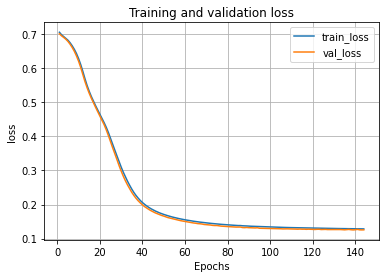

NN
155/155 [==============================] - 0s 970us/step
0.9394246353322528
39/39 [==============================] - 0s 1ms/step
0.9408906882591093


In [22]:
# XGBOOST
from xgboost import XGBClassifier
clf_xgb = XGBClassifier(n_estimators=60, use_label_encoder=False, eval_metric='logloss', random_state=rnd)
clf_xgb.fit(X_train, y_train)
pickle.dump(clf_xgb,open('./blackboxes/compas_xgboost.p','wb'))
clf_xgb = pickle.load(open('./blackboxes/compas_xgboost.p','rb'))
def predict(x, return_proba=False):
    if return_proba:
        return clf_xgb.predict_proba(x)[:,1].ravel()
    else: return clf_xgb.predict(x).ravel().ravel()
y_train_pred = predict(X_train)
y_test_pred = predict(X_test)
print('XGBOOST')
print('train acc:',np.mean(np.round(y_train_pred)==y_train))
print('test acc:',np.mean(np.round(y_test_pred)==y_test))

# RF
from sklearn.ensemble import RandomForestClassifier
clf_rf = RandomForestClassifier(max_depth=12,random_state=rnd)
clf_rf.fit(X_train, y_train)
pickle.dump(clf_rf,open('./blackboxes/compas_rf.p','wb'))
clf_rf = pickle.load(open('./blackboxes/compas_rf.p','rb'))
def predict(x, return_proba=False):
    if return_proba:
        return clf_rf.predict_proba(x)[:,1].ravel()
    else: return clf_rf.predict(x).ravel().ravel()
y_test_pred = predict(X_test, return_proba=True)
y_train_pred = predict(X_train, return_proba=True)
print('RF')
print('train acc:',np.mean(np.round(y_train_pred)==y_train))
print('test acc:',np.mean(np.round(y_test_pred)==y_test))

# SVC
from sklearn.svm import SVC
clf_svc = SVC(gamma='auto', probability=True)
clf_svc.fit(X_train, y_train)
pickle.dump(clf_svc,open('./blackboxes/compas_svc.p','wb'))
clf_svc = pickle.load(open('./blackboxes/compas_svc.p','rb'))
def predict(x, return_proba=False):
    if return_proba:
        return clf_svc.predict_proba(x)[:,1].ravel()
    else: return clf_svc.predict(x).ravel().ravel()
y_train_pred = predict(X_train, return_proba=True)
y_test_pred = predict(X_test, return_proba=True)
print('SVC')
print('train acc:',np.mean(np.round(y_train_pred)==y_train))
print('test acc:',np.mean(np.round(y_test_pred)==y_test))

# NN
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping
BATCH_SIZE = 1024
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(2048).batch(BATCH_SIZE)
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(BATCH_SIZE)
clf_nn = keras.Sequential([
    keras.layers.Dense(units=10, activation='relu'),
    keras.layers.Dense(units=5, activation='relu'),
    keras.layers.Dense(units=1, activation='sigmoid'),
])
early_stopping = EarlyStopping(patience=5)
clf_nn.compile(optimizer='adam', 
              loss='binary_crossentropy',
              metrics=['accuracy'])
history = clf_nn.fit(
    train_dataset,
    validation_data=test_dataset,
    epochs=1000,
    callbacks=[early_stopping],
    verbose=0
    )
def plot_metric(history, metric):
    train_metrics = history.history[metric]
    val_metrics = history.history['val_'+metric]
    epochs = range(1, len(train_metrics) + 1)
    plt.plot(epochs, train_metrics)
    plt.plot(epochs, val_metrics)
    plt.title('Training and validation '+ metric)
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.grid()
    plt.legend(["train_"+metric, 'val_'+metric])
    plt.show()
plot_metric(history, 'loss')
clf_nn.save_weights('./blackboxes/compas_tf_nn')
from sklearn.metrics import accuracy_score
clf_nn.load_weights('./blackboxes/compas_tf_nn')
clf_nn.trainable = False
def predict(x, return_proba=False):
    if return_proba:
        return clf_nn.predict(x).ravel()
    else: return np.round(clf_nn.predict(x).ravel()).astype(int).ravel()
print('NN')
print(accuracy_score(np.round(predict(X_train, return_proba = True)),y_train))
print(accuracy_score(np.round(predict(X_test, return_proba = True)),y_test))

In [119]:
black_box = 'nn'

if black_box=='xgb':
    def predict(x, return_proba=False):
        if return_proba:
            return clf_xgb.predict_proba(x)[:,1].ravel()
        else: return clf_xgb.predict(x).ravel().ravel()
    y_test_pred = predict(X_test, return_proba=True)
    y_train_pred = predict(X_train, return_proba=True)
    y_train_bb = predict(X_train, return_proba=False)
    y_test_bb = predict(X_test, return_proba=False)
elif black_box=='rf':
    def predict(x, return_proba=False):
        if return_proba:
            return clf_rf.predict_proba(x)[:,1].ravel()
        else: return clf_rf.predict(x).ravel().ravel()
    y_test_pred = predict(X_test, return_proba=True)
    y_train_pred = predict(X_train, return_proba=True)
    y_train_bb = predict(X_train, return_proba=False)
    y_test_bb = predict(X_test, return_proba=False)
elif black_box=='svc':
    def predict(x, return_proba=False):
        if return_proba:
            return clf_svc.predict_proba(x)[:,1].ravel()
        else: return clf_svc.predict(x).ravel().ravel()
    y_test_pred = predict(X_test, return_proba=True)
    y_train_pred = predict(X_train, return_proba=True)
    y_train_bb = predict(X_train, return_proba=False)
    y_test_bb = predict(X_test, return_proba=False)
elif black_box=='nn':
    def predict(x, return_proba=False):
        if return_proba:
            return clf_nn.predict(x).ravel()
        else: return np.round(clf_nn.predict(x).ravel()).astype(int).ravel()
    y_test_pred = predict(X_test, return_proba=True)
    y_train_pred = predict(X_train, return_proba=True)
    y_train_bb = predict(X_train, return_proba=False)
    y_test_bb = predict(X_test, return_proba=False)

39/39 [==============================] - 0s 988us/step


# Baseline 1-KNN

In [120]:
from sklearn.neighbors import KNeighborsClassifier
neigh = KNeighborsClassifier(n_neighbors=1)
neigh.fit(X_train, y_train_bb)

print(accuracy_score(neigh.predict(X_test),y_test_bb))

0.9635627530364372


# Proto Select

In [121]:
from alibi.prototypes import ProtoSelect
from alibi.utils.kernel import EuclideanDistance

summariser = ProtoSelect(kernel_distance=EuclideanDistance(), eps=0.5)
summariser = summariser.fit(X=X_train.values, y=y_train_bb)
summary = summariser.summarise(num_prototypes=10)

In [122]:
proto_select = pd.DataFrame(summary.prototypes, columns=X_train.columns)
proto_select

,age,juv_fel_count,decile_score,juv_misd_count,juv_other_count,priors_count,days_b_screening_arrest,c_days_from_compas,decile_score.1,v_decile_score,priors_count.1,start,end,Female,Male,African-American,Asian,Caucasian,Hispanic,Native American,Other,charge_degree_F,charge_degree_M,score_text_high,score_text_low,score_text_medium,v_score_text_high,v_score_text_low,v_score_text_medium,event_0,event_1,not_violent_recid,violent_recid
0,-0.256410,-1.0,-1.000000,-1.0,-1.0,-1.000000,-0.033333,-0.999789,-1.000000,-1.000000,-1.000000,-1.000000,0.556492,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
1,-0.358974,-1.0,-1.000000,-1.0,-1.0,-0.894737,-0.033333,-0.999789,-1.000000,-1.000000,-0.894737,-1.000000,0.568297,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
2,-0.435897,-1.0,-1.000000,-1.0,-1.0,-0.947368,-0.033333,-0.999789,-1.000000,-1.000000,-0.947368,-0.997866,0.573356,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
3,-0.435897,-1.0,-1.000000,-1.0,-1.0,-0.947368,-0.033333,-0.999578,-1.000000,-0.777778,-0.947368,-1.000000,0.595278,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
4,-0.282051,-1.0,-1.000000,-1.0,-1.0,-1.000000,-0.033333,-0.999789,-1.000000,-1.000000,-1.000000,-1.000000,0.608769,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
5,-0.743590,-1.0,-0.777778,-1.0,-1.0,-1.000000,0.000000,-0.999789,-0.777778,-0.555556,-1.000000,-1.000000,0.629005,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
6,-0.358974,-1.0,-1.000000,-1.0,-1.0,-1.000000,-0.033333,-0.999789,-1.000000,-1.000000,-1.000000,-1.000000,0.556492,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
7,-0.769231,-1.0,-0.777778,-1.0,-1.0,-1.000000,-0.033333,-0.999789,-0.777778,-0.777778,-1.000000,-1.000000,0.608769,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
8,-0.923077,-1.0,0.111111,-1.0,-1.0,-0.947368,-0.033333,-0.999789,0.111111,0.111111,-0.947368,-0.997866,-0.654300,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0
9,-0.794872,-1.0,-0.555556,-1.0,-1.0,-1.000000,-0.033333,-0.999789,-0.555556,-0.555556,-1.000000,-1.000000,-0.568297,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0


In [123]:
proto_pred = predict(proto_select)
print('perc positive proto: ', np.mean(proto_pred))

from scipy.spatial.distance import cdist
knn_1 = np.argmin(cdist(proto_select.values, X_test),axis=0)
d = {}
for i in range(len(proto_pred)):
    d[i]=proto_pred[i]
knn_1 = [d[x] for x in knn_1]
print('accuracy 1-KNN:',accuracy_score(knn_1,y_test_bb))

print('avg_distance:',np.mean(cdist(proto_select.values,proto_select.values)))

1/1 [==============================] - 0s 21ms/step
perc positive proto:  0.2
accuracy 1-KNN: 0.8599190283400809
avg_distance: 2.003737945744867


# ProtoDASH

In [124]:
X_train

,age,juv_fel_count,decile_score,juv_misd_count,juv_other_count,priors_count,days_b_screening_arrest,c_days_from_compas,decile_score.1,v_decile_score,priors_count.1,start,end,Female,Male,African-American,Asian,Caucasian,Hispanic,Native American,Other,charge_degree_F,charge_degree_M,score_text_high,score_text_low,score_text_medium,v_score_text_high,v_score_text_low,v_score_text_medium,event_0,event_1,not_violent_recid,violent_recid
6549,-0.384615,-1.0,-0.333333,-1.0,-1.000000,-0.578947,-0.033333,-0.999789,-0.333333,-0.333333,-0.578947,-1.000000,-0.919056,0,1,0,0,1,0,0,0,1,0,0,1,0,0,1,0,1,0,1,0
2294,-0.871795,-1.0,0.333333,-1.0,-1.000000,-0.842105,0.000000,-0.999789,0.333333,-0.111111,-0.842105,-0.997866,0.269815,0,1,1,0,0,0,0,0,1,0,0,0,1,0,0,1,1,0,1,0
1356,-0.564103,-1.0,-0.777778,-1.0,-1.000000,-0.842105,-0.033333,-0.999789,-0.777778,-0.777778,-0.842105,-0.978655,0.391231,0,1,1,0,0,0,0,0,0,1,0,1,0,0,1,0,1,0,1,0
525,-0.820513,-1.0,-0.333333,-1.0,-1.000000,-0.789474,-0.166667,-0.998735,-0.333333,-0.555556,-0.789474,-1.000000,-0.708263,0,1,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,1,1,0
1518,-0.641026,-1.0,0.555556,-1.0,-1.000000,-0.368421,-0.033333,-0.999789,0.555556,0.111111,-0.368421,-1.000000,0.841484,0,1,1,0,0,0,0,0,1,0,1,0,0,0,0,1,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
602,-0.487179,-1.0,-1.000000,-1.0,-1.000000,-0.947368,-0.033333,-0.999789,-1.000000,-1.000000,-0.947368,-1.000000,0.822934,1,0,1,0,0,0,0,0,1,0,0,1,0,0,1,0,1,0,1,0
3039,-0.564103,-1.0,-0.333333,-1.0,-1.000000,-0.947368,-0.033333,-0.999789,-0.333333,-0.777778,-0.947368,-1.000000,0.998314,1,0,0,0,1,0,0,0,0,1,0,1,0,0,1,0,1,0,1,0
5725,-0.846154,-1.0,0.111111,-1.0,-1.000000,-1.000000,0.000000,-0.999789,0.111111,-0.111111,-1.000000,-1.000000,0.860034,1,0,0,0,1,0,0,0,0,1,0,0,1,0,0,1,1,0,1,0
7213,-0.871795,-1.0,-0.333333,-1.0,-1.000000,-0.894737,-0.066667,-0.999578,-0.333333,-0.333333,-0.894737,-1.000000,-0.564924,1,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,1,0,1,0


In [125]:
from protodash import ProtodashExplainer, get_Gaussian_Data

explainer = ProtodashExplainer()

# call protodash explainer
# S contains indices of the selected prototypes
# W contains importance weights associated with the selected prototypes 
(W, S, _) = explainer.explain(X_train.values, X_train.values, m=10) 

In [126]:
proto_dash = X_train.iloc[S, :].copy()
proto_dash

,age,juv_fel_count,decile_score,juv_misd_count,juv_other_count,priors_count,days_b_screening_arrest,c_days_from_compas,decile_score.1,v_decile_score,priors_count.1,start,end,Female,Male,African-American,Asian,Caucasian,Hispanic,Native American,Other,charge_degree_F,charge_degree_M,score_text_high,score_text_low,score_text_medium,v_score_text_high,v_score_text_low,v_score_text_medium,event_0,event_1,not_violent_recid,violent_recid
5698,-0.692308,-1.0,-0.333333,-1.000000,-1.000000,-1.000000,0.000000,-0.999789,-0.333333,-0.555556,-1.000000,-0.991462,0.129848,0,1,1,0,0,0,0,0,1,0,0,1,0,0,1,0,1,0,1,0
6967,-0.923077,-1.0,-0.111111,-1.000000,-1.000000,-1.000000,-0.033333,-0.999789,-0.111111,0.111111,-1.000000,-0.997866,-0.971332,1,0,0,0,1,0,0,0,0,1,0,0,1,0,0,1,0,1,1,0
4922,-0.205128,-1.0,0.555556,-1.000000,-1.000000,-0.789474,-0.266667,-0.998313,0.555556,-0.555556,-0.789474,-1.000000,0.767285,0,1,0,0,1,0,0,0,0,1,1,0,0,0,1,0,0,1,0,1
328,-0.102564,-1.0,0.111111,-1.000000,-1.000000,0.894737,-0.233333,-0.998524,0.111111,0.777778,0.894737,-0.944504,-0.750422,0,1,0,0,1,0,0,0,1,0,0,0,1,1,0,0,1,0,1,0
2610,1.000000,-1.0,-0.777778,-1.000000,-1.000000,-0.894737,-0.100000,-0.999367,-0.777778,-1.000000,-0.894737,-1.000000,-0.699831,0,1,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,1,0
2509,-0.692308,-1.0,-1.000000,-0.846154,-0.777778,-0.842105,-0.033333,-0.999789,-1.000000,-1.000000,-0.842105,-1.000000,0.861720,0,1,0,0,0,0,0,1,0,1,0,1,0,0,1,0,1,0,1,0
5686,-0.564103,-1.0,0.555556,-1.000000,-1.000000,-0.157895,-0.033333,-0.999789,0.555556,0.111111,-0.157895,0.308431,0.812816,0,1,1,0,0,0,0,0,1,0,1,0,0,0,0,1,0,1,1,0
2830,-0.871795,-1.0,0.555556,-1.000000,-1.000000,-1.000000,-0.033333,-0.999789,0.555556,0.555556,-1.000000,-0.997866,-0.964587,0,1,1,0,0,0,0,0,1,0,1,0,0,1,0,0,1,0,0,1
4825,-0.435897,-1.0,-0.111111,-1.000000,-1.000000,-1.000000,0.000000,-0.999789,-0.111111,-1.000000,-1.000000,-0.861259,0.554806,0,1,0,0,0,1,0,0,1,0,0,0,1,0,1,0,1,0,1,0
4188,-0.179487,-1.0,-1.000000,-1.000000,-1.000000,-0.368421,-0.733333,-0.995361,-1.000000,-1.000000,-0.368421,-1.000000,-0.522766,0,1,1,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,1,0


In [127]:
proto_pred = predict(proto_dash)
print('perc positive proto: ', np.mean(proto_pred))

from scipy.spatial.distance import cdist
knn_1 = np.argmin(cdist(proto_dash.values, X_test),axis=0)
d = {}
for i in range(10):
    d[i]=proto_pred[i]
knn_1 = [d[x] for x in knn_1]
print('accuracy 1-KNN:',accuracy_score(knn_1,y_test_bb))

print('avg_distance:',np.mean(cdist(proto_dash.values,proto_dash.values)))

1/1 [==============================] - 0s 20ms/step
perc positive proto:  0.6
accuracy 1-KNN: 0.8461538461538461
avg_distance: 3.2779439576552734


# MMD Critic

In [128]:
from mmd.mmd_critic import Dataset, select_prototypes, select_criticisms

#gamma = 0.026
gamma = 0.3

num_prototypes = 10
num_criticisms = 10

kernel_type = 'local'
# kernel_type = 'global'

# regularizer = None
regularizer = 'logdet'
# regularizer = 'iterative'

d_train = Dataset(torch.tensor(X_train.values, dtype=torch.float), torch.tensor(y_train_bb,dtype=torch.long))
if kernel_type == 'global':
    d_train.compute_rbf_kernel(gamma)
elif kernel_type == 'local':
    d_train.compute_local_rbf_kernel(gamma)
else:
    raise KeyError('kernel_type must be either "global" or "local"')
print('Done.', flush=True)

# Prototypes
print('Computing prototypes...', end='', flush=True)
prototype_indices = select_prototypes(d_train.K, num_prototypes)

prototypes = d_train.X[prototype_indices]
prototype_labels = d_train.y[prototype_indices]

sorted_by_y_indices = prototype_labels.argsort()
prototypes_sorted = prototypes[sorted_by_y_indices]
prototype_labels = prototype_labels[sorted_by_y_indices]
print('Done.', flush=True)
print(prototype_indices.sort()[0].tolist())

# Criticisms
print('Computing criticisms...', end='', flush=True)
criticism_indices = select_criticisms(d_train.K, prototype_indices, num_criticisms, regularizer)

criticisms = d_train.X[criticism_indices]
criticism_labels = d_train.y[criticism_indices]

sorted_by_y_indices = criticism_labels.argsort()
criticisms_sorted = criticisms[sorted_by_y_indices]
criticism_labels = criticism_labels[sorted_by_y_indices]
print('Done.', flush=True)
print(criticism_indices.sort()[0].tolist())

Done.
Computing prototypes...Done.
[151, 595, 613, 798, 1426, 1602, 3198, 3688, 4160, 4748]
Computing criticisms...Done.
[256, 1091, 1685, 2584, 2947, 3052, 3491, 4668, 4801, 4918]


In [129]:
proto_mmd = X_train.iloc[prototype_indices.sort()[0].tolist()]
proto_mmd

,age,juv_fel_count,decile_score,juv_misd_count,juv_other_count,priors_count,days_b_screening_arrest,c_days_from_compas,decile_score.1,v_decile_score,priors_count.1,start,end,Female,Male,African-American,Asian,Caucasian,Hispanic,Native American,Other,charge_degree_F,charge_degree_M,score_text_high,score_text_low,score_text_medium,v_score_text_high,v_score_text_low,v_score_text_medium,event_0,event_1,not_violent_recid,violent_recid
2595,-0.666667,-1.0,0.333333,-1.0,-1.0,-0.684211,-0.033333,-0.999789,0.333333,-0.555556,-0.684211,-0.980790,0.347386,0,1,0,0,1,0,0,0,0,1,0,0,1,0,1,0,1,0,1,0
6467,-0.461538,-1.0,-0.777778,-1.0,-1.0,-0.894737,0.000000,-1.000000,-0.777778,-0.777778,-0.894737,-0.961580,0.463744,0,1,0,0,1,0,0,0,1,0,0,1,0,0,1,0,1,0,1,0
2160,-0.435897,-1.0,-0.777778,-1.0,-1.0,-0.842105,-0.033333,-0.999789,-0.777778,-1.000000,-0.842105,-1.000000,0.922428,0,1,1,0,0,0,0,0,1,0,0,1,0,0,1,0,1,0,1,0
3903,-0.051282,-1.0,-1.000000,-1.0,-1.0,-1.000000,-0.233333,-0.998524,-1.000000,-1.000000,-1.000000,-1.000000,0.242833,0,1,0,0,0,1,0,0,0,1,0,1,0,0,1,0,1,0,1,0
5737,-0.794872,-1.0,-0.333333,-1.0,-1.0,-0.947368,-0.066667,-0.999578,-0.333333,-0.555556,-0.947368,-1.000000,0.295110,1,0,0,0,1,0,0,0,0,1,0,1,0,0,1,0,0,1,1,0
4856,-0.692308,-1.0,-0.555556,-1.0,-1.0,-0.894737,-0.033333,-0.999789,-0.555556,-0.777778,-0.894737,-1.000000,0.595278,1,0,1,0,0,0,0,0,0,1,0,1,0,0,1,0,1,0,1,0
1323,-0.641026,-1.0,-0.555556,-1.0,-1.0,-0.789474,0.000000,-0.999789,-0.555556,-0.777778,-0.789474,-1.000000,0.888702,0,1,0,0,0,0,0,1,1,0,0,1,0,0,1,0,1,0,1,0
5403,-0.846154,-1.0,0.777778,-1.0,-1.0,-0.736842,-0.033333,-0.999789,0.777778,0.333333,-0.736842,-0.987193,-0.809444,0,1,1,0,0,0,0,0,1,0,1,0,0,0,0,1,0,1,1,0
6118,-0.564103,-1.0,-0.111111,-1.0,-1.0,-0.842105,0.000000,-1.000000,-0.111111,-0.333333,-0.842105,-0.997866,-0.568297,0,1,0,0,1,0,0,0,0,1,0,0,1,0,1,0,0,1,1,0
3594,-0.948718,-1.0,-0.333333,-1.0,-1.0,-1.000000,-0.033333,-0.999789,-0.333333,0.333333,-1.000000,-1.000000,0.617201,0,1,0,0,1,0,0,0,1,0,0,1,0,0,0,1,1,0,1,0


In [130]:
proto_pred = predict(proto_mmd)
print('perc positive proto: ', np.mean(proto_pred))

from scipy.spatial.distance import cdist
knn_1 = np.argmin(cdist(proto_mmd.values, X_test),axis=0)
d = {}
for i in range(10):
    d[i]=proto_pred[i]
knn_1 = [d[x] for x in knn_1]
print('accuracy 1-KNN:',accuracy_score(knn_1,y_test_bb))

print('avg_distance:',np.mean(cdist(proto_mmd.values,proto_mmd.values)))

1/1 [==============================] - 0s 22ms/step
perc positive proto:  0.3
accuracy 1-KNN: 0.8502024291497976
avg_distance: 2.533888833723696


# Latent

In [137]:
X_train

,age,juv_fel_count,decile_score,juv_misd_count,juv_other_count,priors_count,days_b_screening_arrest,c_days_from_compas,decile_score.1,v_decile_score,priors_count.1,start,end,Female,Male,African-American,Asian,Caucasian,Hispanic,Native American,Other,charge_degree_F,charge_degree_M,score_text_high,score_text_low,score_text_medium,v_score_text_high,v_score_text_low,v_score_text_medium,event_0,event_1,not_violent_recid,violent_recid
6549,-0.384615,-1.0,-0.333333,-1.0,-1.000000,-0.578947,-0.033333,-0.999789,-0.333333,-0.333333,-0.578947,-1.000000,-0.919056,0,1,0,0,1,0,0,0,1,0,0,1,0,0,1,0,1,0,1,0
2294,-0.871795,-1.0,0.333333,-1.0,-1.000000,-0.842105,0.000000,-0.999789,0.333333,-0.111111,-0.842105,-0.997866,0.269815,0,1,1,0,0,0,0,0,1,0,0,0,1,0,0,1,1,0,1,0
1356,-0.564103,-1.0,-0.777778,-1.0,-1.000000,-0.842105,-0.033333,-0.999789,-0.777778,-0.777778,-0.842105,-0.978655,0.391231,0,1,1,0,0,0,0,0,0,1,0,1,0,0,1,0,1,0,1,0
525,-0.820513,-1.0,-0.333333,-1.0,-1.000000,-0.789474,-0.166667,-0.998735,-0.333333,-0.555556,-0.789474,-1.000000,-0.708263,0,1,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,1,1,0
1518,-0.641026,-1.0,0.555556,-1.0,-1.000000,-0.368421,-0.033333,-0.999789,0.555556,0.111111,-0.368421,-1.000000,0.841484,0,1,1,0,0,0,0,0,1,0,1,0,0,0,0,1,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
602,-0.487179,-1.0,-1.000000,-1.0,-1.000000,-0.947368,-0.033333,-0.999789,-1.000000,-1.000000,-0.947368,-1.000000,0.822934,1,0,1,0,0,0,0,0,1,0,0,1,0,0,1,0,1,0,1,0
3039,-0.564103,-1.0,-0.333333,-1.0,-1.000000,-0.947368,-0.033333,-0.999789,-0.333333,-0.777778,-0.947368,-1.000000,0.998314,1,0,0,0,1,0,0,0,0,1,0,1,0,0,1,0,1,0,1,0
5725,-0.846154,-1.0,0.111111,-1.0,-1.000000,-1.000000,0.000000,-0.999789,0.111111,-0.111111,-1.000000,-1.000000,0.860034,1,0,0,0,1,0,0,0,0,1,0,0,1,0,0,1,1,0,1,0
7213,-0.871795,-1.0,-0.333333,-1.0,-1.000000,-0.894737,-0.066667,-0.999578,-0.333333,-0.333333,-0.894737,-1.000000,-0.564924,1,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,1,0,1,0


In [132]:
X_train_latent = np.hstack((X_train,y_train_pred.reshape(-1,1)))
X_test_latent = np.hstack((X_test,y_test_pred.reshape(-1,1)))
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

# Latent Space

latent_dim = 15
batch_size = 1024
sigma = 1
max_epochs = 1000
early_stopping = 3
learning_rate = 1e-3

idx_cat = list(range(2,17))

similarity_KLD = torch.nn.KLDivLoss(reduction='batchmean')

def compute_similarity_Z(Z, sigma):
    D = 1 - F.cosine_similarity(Z[:, None, :], Z[None, :, :], dim=-1)
    M = torch.exp((-D**2)/(2*sigma**2))
    return M / (torch.ones([M.shape[0],M.shape[1]])*(torch.sum(M, axis = 0)-1)).transpose(0,1)

def compute_similarity_X(X, sigma, idx_cat=None):
    D_class = torch.cdist(X[:,-1].reshape(-1,1),X[:,-1].reshape(-1,1))
    X = X[:, :-1]
    if idx_cat:
        X_cat = X[:, idx_cat]
        X_cont = X[:, np.delete(range(X.shape[1]),idx_cat)]
        h = X_cat.shape[1]
        m = X.shape[1]
        D_cont = 1 - F.cosine_similarity(X[:, None, :], X[None, :, :], dim=-1)
        D_cat = torch.cdist(X_cat, X_cat, p=0)/h
        D = h/m * D_cat + ((m-h)/m) * D_cont + D_class
    else:
        D_features = 1 - F.cosine_similarity(X[:, None, :], X[None, :, :], dim=-1) 
        D = D_features + D_class
    M = torch.exp((-D**2)/(2*sigma**2))
    return M / (torch.ones([M.shape[0],M.shape[1]])*(torch.sum(M, axis = 0)-1)).transpose(0,1)

def loss_function(X, Z, idx_cat, sigma=1):
    Sx = compute_similarity_X(X, sigma, idx_cat)
    Sz = compute_similarity_Z(Z, sigma)
    loss = similarity_KLD(torch.log(Sx), Sz)
    return loss

class LinearModel(nn.Module):
    def __init__(self, input_shape, latent_dim):
        super(LinearModel, self).__init__()

        # encoding components
        self.fc1 = nn.Linear(input_shape, latent_dim)

    def encode(self, x):
        x = self.fc1(x)
        return x

    def forward(self, x):
        z = self.encode(x)
        return z

# Create Model
model = LinearModel(X_train_latent.shape[1], latent_dim=latent_dim)

In [133]:
train_dataset = TensorDataset(torch.tensor(X_train_latent).float())
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True) 
test_dataset = TensorDataset(torch.tensor(X_test_latent).float())
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False) 

def check_and_clear(dir_name):
    if not os.path.exists(dir_name):
        os.mkdir(dir_name)
    else:
        os.system('rm -r ' + dir_name)
        os.mkdir(dir_name)

check_and_clear('./models/weights')

model_params = list(model.parameters())
optimizer = torch.optim.Adam(model_params, lr=learning_rate)

# record training process
epoch_train_losses = []
epoch_test_losses = []

#validation parameters
epoch = 1
best = np.inf

# progress bar
pbar = tqdm(bar_format="{postfix[0]} {postfix[1][value]:03d} {postfix[2]} {postfix[3][value]:.5f} {postfix[4]} {postfix[5][value]:.5f} {postfix[6]} {postfix[7][value]:d}",
            postfix=["Epoch:", {'value':0}, "Train Sim Loss", {'value':0}, "Test Sim Loss", {'value':0}, "Early Stopping", {"value":0}])

# start training
while epoch <= max_epochs:

    # ------- TRAIN ------- #
    # set model as training mode
    model.train()
    batch_loss = []

    for batch, (X_batch,) in enumerate(train_loader):
        optimizer.zero_grad()
        Z_batch = model(X_batch)  #
        loss  = loss_function(X_batch, Z_batch, idx_cat, sigma) 
        loss.backward()
        optimizer.step()
        batch_loss.append(loss.item())

    # save result
    epoch_train_losses.append(np.mean(batch_loss))
    pbar.postfix[3]["value"] = np.mean(batch_loss)

    # -------- VALIDATION --------

    # set model as testing mode
    model.eval()
    batch_loss = []

    with torch.no_grad():
        for batch, (X_batch,) in enumerate(test_loader):
            Z_batch = model(X_batch)
            loss = loss_function(X_batch, Z_batch, idx_cat, sigma)
            batch_loss.append(loss.item())

    # save information
    epoch_test_losses.append(np.mean(batch_loss))
    pbar.postfix[5]["value"] = np.mean(batch_loss)
    pbar.postfix[1]["value"] = epoch

    if epoch_test_losses[-1] < best:
        wait = 0
        best = epoch_test_losses[-1]
        best_epoch = epoch
        torch.save(model.state_dict(), f'./models/weights/LinearTransparent_compas.pt')
    else:
        wait += 1
    pbar.postfix[7]["value"] = wait
    if wait == early_stopping:
        break    
    epoch += 1
    pbar.update()

model.load_state_dict(torch.load(f'./models/weights/LinearTransparent_compas.pt'))
with torch.no_grad():
    model.eval()
    Z_train = model(torch.tensor(X_train_latent).float()).cpu().detach().numpy()
    Z_test = model(torch.tensor(X_test_latent).float()).cpu().detach().numpy()

torch.save(model.state_dict(), f'./models/compas_latent_{black_box}_{latent_dim}.pt')

Epoch: 216 Train Sim Loss 0.00110 Test Sim Loss 0.00087 Early Stopping 3


In [134]:
model.load_state_dict(torch.load(f'./models/compas_latent_{black_box}_{latent_dim}.pt'))
with torch.no_grad():
    model.eval()
    Z_train = model(torch.tensor(X_train_latent).float()).cpu().detach().numpy()
    Z_test = model(torch.tensor(X_test_latent).float()).cpu().detach().numpy()

## Latent Clustering

In [135]:
np.mean(y_train==1)

0.455226904376013

In [136]:
from sklearn.cluster import SpectralClustering, KMeans

Z_train_0 = Z_train[y_train==0]
Z_train_1 = Z_train[y_train==1]

n = 10

clustering_0 = SpectralClustering(n_clusters=int(n//(1/0.50)),assign_labels='discretize').fit(Z_train_0)
clustering_1 = SpectralClustering(n_clusters=int(n-n//(1/0.50)),assign_labels='discretize').fit(Z_train_1)

centers = []
for i in range(int(n//(1/0.50))):
    centers.append(np.mean(Z_train_0[clustering_0.labels_==i],axis=0))
for i in range(int(n-n//(1/0.50))):
    centers.append(np.mean(Z_train_1[clustering_1.labels_==i],axis=0))
centers = np.stack(centers)

from scipy.spatial.distance import cdist
idx = np.argmin(cdist(centers,Z_train),axis=1)
proto_latent_clustering = pd.DataFrame(X_train_latent[idx,:-1],columns=X_train.columns)

proto_pred = predict(proto_latent_clustering)
print('perc positive proto: ', np.mean(proto_pred))

from scipy.spatial.distance import cdist
knn_1 = np.argmin(cdist(proto_latent_clustering.values, X_test_latent[:,:-1]),axis=0)
d = {}
for i in range(n):
    d[i]=proto_pred[i]
knn_1 = [d[x] for x in knn_1]
print('accuracy 1-KNN:',accuracy_score(knn_1,y_test_bb))

print('avg_distance:',np.mean(cdist(proto_latent_clustering.values,proto_latent_clustering.values)))

1/1 [==============================] - 0s 19ms/step
perc positive proto:  0.5
accuracy 1-KNN: 0.8834008097165992
avg_distance: 2.348476879214055


In [ ]:
import pickle
results = pickle.load(open('results_proto_compas.pickle','rb'))

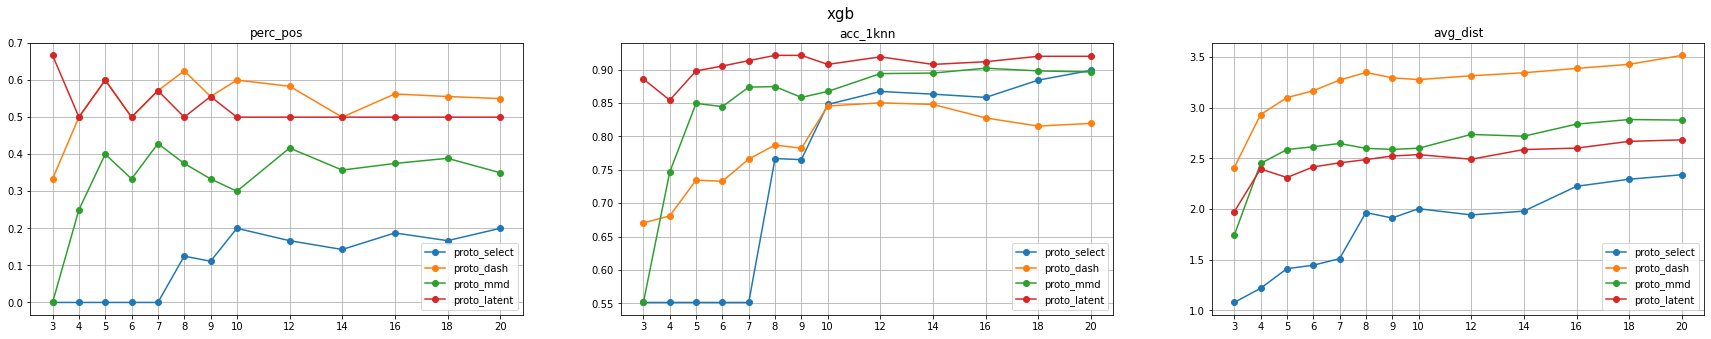

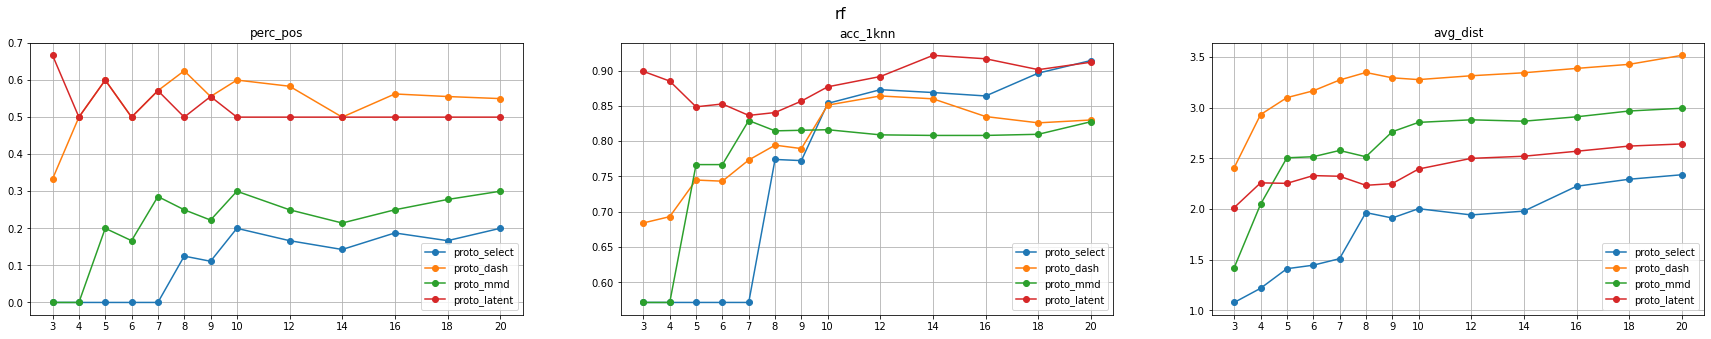

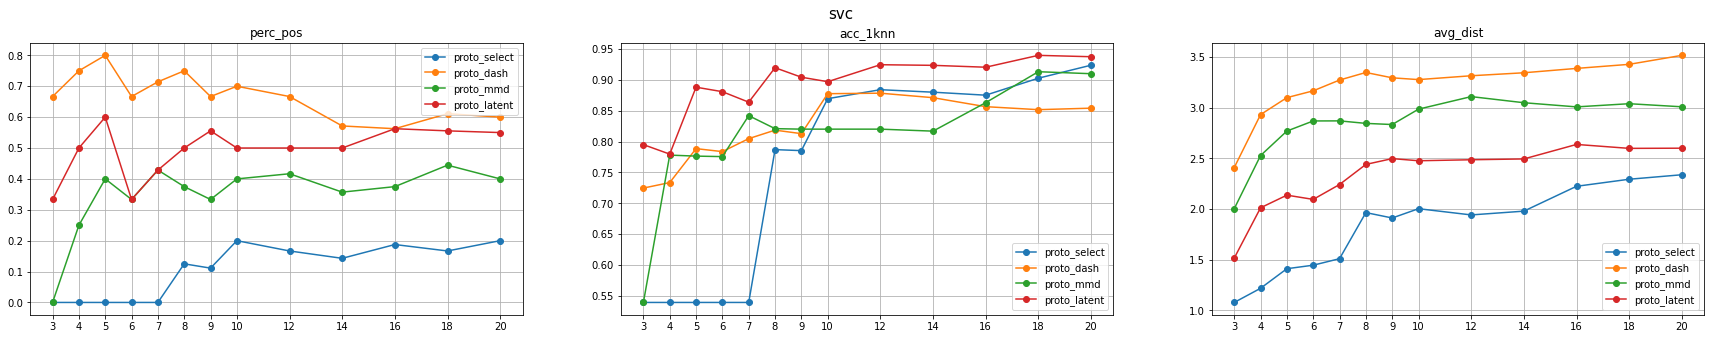

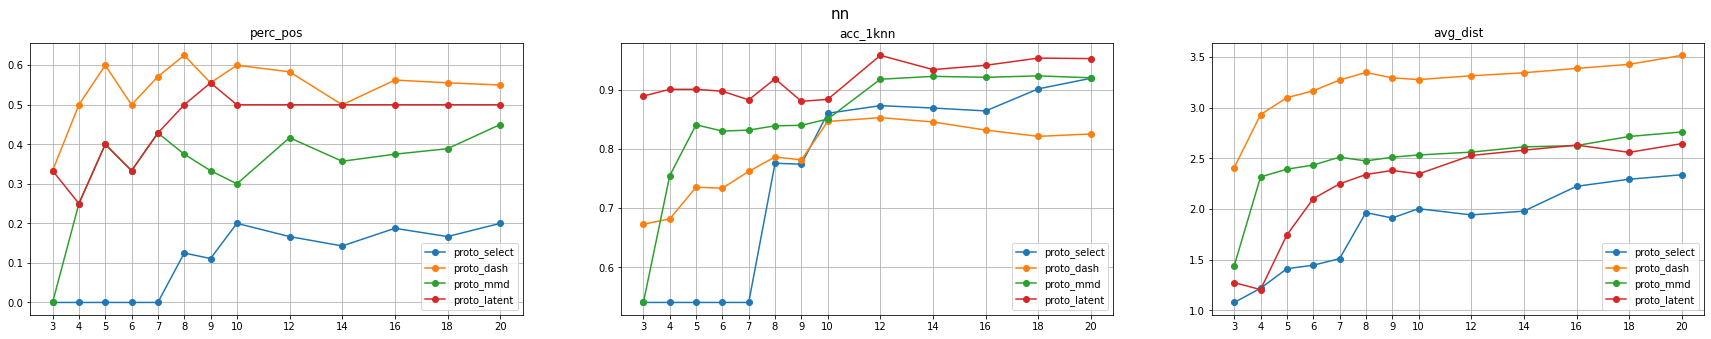

In [159]:
for bb in ['xgb', 'rf', 'svc', 'nn']:
    r =[]
    for method in ['proto_select', 'proto_dash', 'proto_mmd', 'proto_latent']:
        l = []
        for n in [3,4,5,6,7,8,9,10,12,14,16,18,20]:
            l.append([results[bb][method][f'n_{n}']['perc_pos'],results[bb][method][f'n_{n}']['acc_1knn'],results[bb][method][f'n_{n}']['avg_dist']])
        r.append(np.stack(l))
    r = np.stack(r)

    methods = ['proto_select', 'proto_dash', 'proto_mmd', 'proto_latent']

    fig, ax = plt.subplots(1,3,figsize=(30,5))
    fig.suptitle(bb, fontsize=15)

    for i in range(len(methods)):
        ax[0].plot([3,4,5,6,7,8,9,10,12,14,16,18,20],r[i,:,0],'-o',label=methods[i])
        ax[1].plot([3,4,5,6,7,8,9,10,12,14,16,18,20],r[i,:,1],'-o',label=methods[i])
        ax[2].plot([3,4,5,6,7,8,9,10,12,14,16,18,20],r[i,:,2],'-o',label=methods[i])

    ax[0].set_title('perc_pos')
    ax[1].set_title('acc_1knn')
    ax[2].set_title('avg_dist')

    for i in range(3):
        ax[i].legend()
        ax[i].grid()
        ax[i].set_xticks([3,4,5,6,7,8,9,10,12,14,16,18,20])